In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns



# Regularización

Estudiaremos como la regularización puede ayudarnos a reducir los efectos del bias y la varianza.
Veremos como utilizar regularización en modelos de regresión.




# Recordando regresión




Todos los modelos de regresión lineal aprenden una serie de *coeficientes* (también llamados parámetros o pesos) y un *intercept* (también llamado bias) para realizar una combinación lineal de las características del modelo a aprender. Así tenemos que:

```
y_pred = x_test[0] * coef_[0] + ... + x_test[n_features-1] * coef_[n_features-1] + intercept_
```

Existen varios modelos de regresión lineal cuya principal diferencia reside en las restricciones (regularización) que ponemos en los *coeficientes*.

Generamos in conjunto de datos que nos permita ver el comportamiento de estos modelos.

In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [4]:
X, y, true_coefficient = make_regression(n_samples=200, n_features=30,
                                         n_informative=10, noise=100,
                                         coef=True, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, train_size=60)

print(X_train.shape)
print(y_train.shape)

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html
# genera un problena de regresión

'''
n_samples: The number of samples.
n_features: The number of features.
n_informative: The number of features used to build the linear model used to generate the output.
noise: The standard deviation of the gaussian noise applied to the output.
coef: If True, the coefficients of the underlying linear model are returned.
'''

(60, 30)
(60,)


'\nn_samples: The number of samples.\nn_features: The number of features.\nn_informative: The number of features used to build the linear model used to generate the output.\nnoise: The standard deviation of the gaussian noise applied to the output.\ncoef: If True, the coefficients of the underlying linear model are returned.\n'



## Linear Regression

El modelo lineal más famoso es la regresión OLS (Ordinary Least Squares), llamada *regresión lineal*. Este tipo de regresión no impone ninguna restricción a los coeficientes. Esto significa que cuando tenemos un gran número de caracterísiticas, el modelo tienda a sobreajustar.

$$ \text{min}_{w, b} \sum_i || w^\mathsf{T}x_i + b  - y_i||^2 $$

In [5]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression().fit(X_train, y_train)

In [6]:
print("R^2 on training set: %f" % linear_regression.score(X_train, y_train))
print("R^2 on test set: %f" % linear_regression.score(X_test, y_test))

R^2 on training set: 0.878011
R^2 on test set: 0.216332




Como vemos el $R^2$ en el conjunto de entrenamiento es muy alto, pero muy bajo en el conjunto de test. Esto suele ser un indicativo de que nuestro modelo está sobreajustando.

Evaluaremos como se comporta el modelo real sobre los datos:

In [7]:
from sklearn.metrics import r2_score
print(r2_score(np.dot(X, true_coefficient), y))
# https://numpy.org/doc/stable/reference/generated/numpy.dot.html

0.5985284495875146




Por lo que podemos decir que un $R^2 \approx 0.6$ es un resultado ideal para nuestro conjunto de datos.



Compararemos los coeficientes aprendidos por el modelo con los coeficientes reales de nuestros datos:

In [8]:
true_coefficient[np.argsort(true_coefficient)[::-1]]
# https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

array([88.17735659, 80.81291382, 70.85764943, 64.56924673, 49.25507875,
       34.28961765, 32.29058037, 15.07583458,  8.41487791,  2.12227127,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

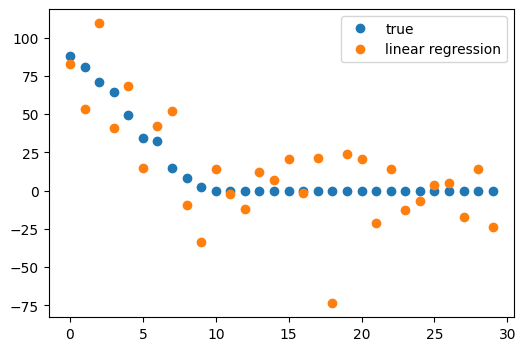

In [9]:
plt.figure(figsize=(6, 4))
coefficient_sorting = np.argsort(true_coefficient)[::-1]

plt.plot(true_coefficient[coefficient_sorting], "o", label="true")
plt.plot(linear_regression.coef_[coefficient_sorting], "o", label="linear regression")

plt.legend()



Un método muy útil para conocer si nuestro modelo sufre de *underfitting* o de *overfitting* es calcular las curvas de aprendizaje. Éstas muestran el score del modelo en los conjuntos de training y de test para un número determinado de muestras de entrenamiento.

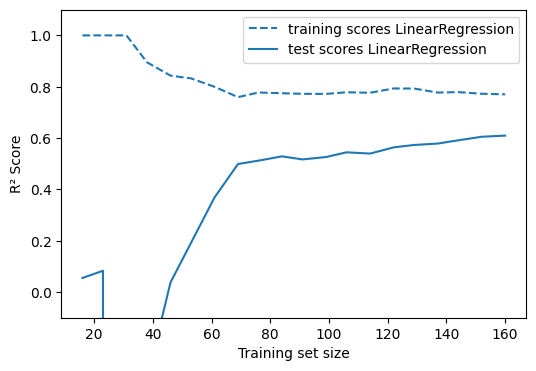

In [10]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, train_sizes=np.linspace(.1, 1, 20))
    estimator_name = est.__class__.__name__
    # print(train_scores)
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.ylabel('R² Score')
    plt.legend(loc='best')
    plt.ylim(-0.1, 1.1)

plt.figure(figsize=(6,4))
plot_learning_curve(LinearRegression(), X, y)

In [11]:
np.linspace(.1, 1, 20)
# https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ])



## Ridge Regression (L2 penalty)

La **Regresión de Ridge** es un método de regularización que impone una restricción a los pesos del modelo de regresión simple. La regresión que impone la Regresión de Ridge se basa en la norma $L2$. Este tipo de regularización tiene la ventaja de no ser mucho más pesada computacionalmente que una regresión por OLS.

$$ \text{min}_{w,b}  \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_2^2$$



Como vemos, la Regresión de Ridge, es muy parecida a la Regresión Lineal. La única diferencia entre ambas es que Ridge añade la norma L2 a la función de minimización.

El parámetro libre $\alpha$ regula la cantidad de regularización que queemos aplicar al modelo. Vamos a probar varios valores de $\alpha$ para evaluar como afecta al performance del modelo:

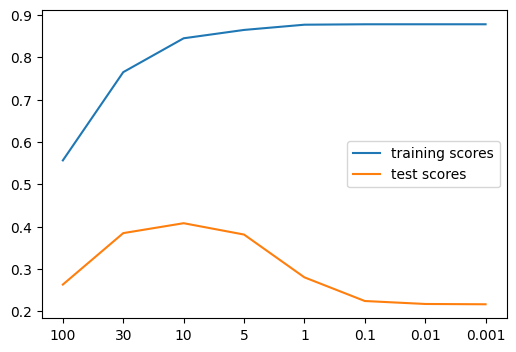

In [12]:
from sklearn.linear_model import Ridge
ridge_models = {}
training_scores = []
test_scores = []
alphas = [100, 30, 10, 5, 1, 0.1, .01, 0.001]
for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    training_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    ridge_models[alpha] = ridge

plt.figure(figsize=(6,4))
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(len(alphas)), alphas)
plt.legend(loc="best")



Tenemos el máximo score en el conjunto de test para $\alpha = 10$.


**EJERCICIO**:

- Qué le ocurre al modelo para valores de $\alpha$ menores a 10?
- Qué le ocurre al modelo par avalores de $\alpha$ mayores a 10?



Vamos a ver lo ocurre con los coeficientes:

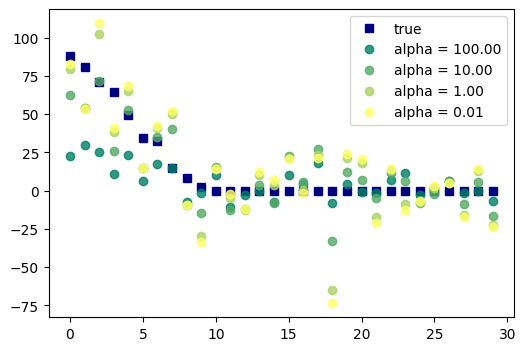

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(true_coefficient[coefficient_sorting], "s", label="true", c='navy')

for i, alpha in enumerate([100, 10, 1, .01]):
    plt.plot(ridge_models[alpha].coef_[coefficient_sorting], "o", label="alpha = %.2f" % alpha, alpha=0.8, c=plt.cm.summer(i / 3.))

plt.legend(loc="best")



- Valores altos de $\alpha$ producen que el modelo tienda a ajustar los pesos a 0.
  - Es decir, aumentan el bias del modelo.
- Valores bajos de $\alpha$ producen que el modelo se comporte como una regresión lineal sin regularización.



En **resumen**: es muy importante elegir el valor óptimo de $\alpha$.



Ahora vamos a ver las curvas de aprendizaje del modelo de Ridge vs la Regresión Lineal.

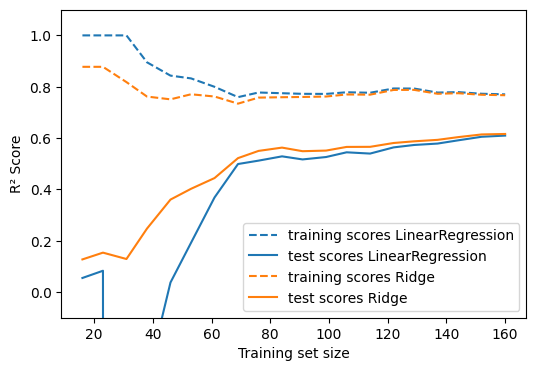

In [14]:
plt.figure(figsize=(6, 4))
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=10), X, y)



## Lasso (penalty L1)

La **Regresión de Lasso** es otro tipo de regularización pero que impone una restrucción utilizando la norma $L1$. Este tipo de regularización es útil cuando creemos que muchas de los parámetros del modelo no son relevantes (como es el caso de nuestro dataset).

$$ \text{min}_{w, b} \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_1$$

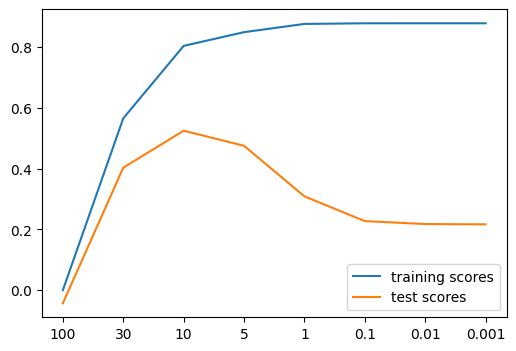

In [15]:
from sklearn.linear_model import Lasso

lasso_models = {}
training_scores = []
test_scores = []

alphas = [100, 30, 10, 5, 1, 0.1, .01, 0.001]
for alpha in alphas:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train)
    training_scores.append(lasso.score(X_train, y_train))
    test_scores.append(lasso.score(X_test, y_test))
    lasso_models[alpha] = lasso
plt.figure(figsize=(6,4))
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(len(alphas)), alphas)
plt.legend(loc="best")

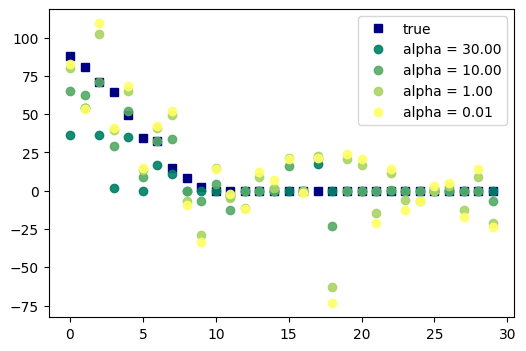

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(true_coefficient[coefficient_sorting], "s", label="true", c='navy')

for i, alpha in enumerate([30, 10, 1, .01]):
    plt.plot(lasso_models[alpha].coef_[coefficient_sorting], "o", label="alpha = %.2f" % alpha, alpha=0.9, c=plt.cm.summer(i / 3.))

plt.legend(loc="best")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.054e+01, tolerance: 4.958e+01
  model = cd_fast.enet_coordinate_descent(


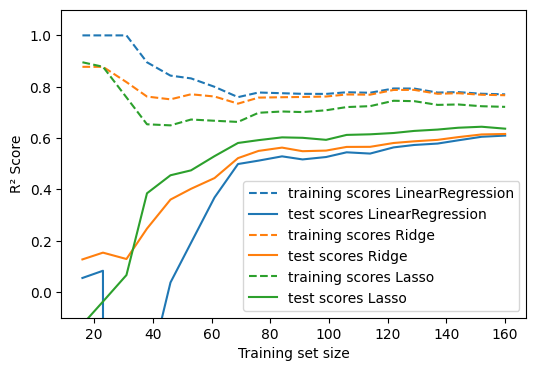

In [17]:
plt.figure(figsize=(6, 4))
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=10), X, y)
plot_learning_curve(Lasso(alpha=10), X, y)



**Nota**: En lugar de tener que elegir entre Ridge o Lasso, es posible utilizar la Regresión [ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), que combina ambas formas de regularización a través de un parámetro de ponderación que nos permite elegir a qué tipo de regularización darle más peso. En muchos casos ElasticNet obtiene un rendimiento mayor que Ridge o Lasso.




# Ejercicio

Hasta ahora hemos mostrado las *learning curves* para un valor de $\alpha = 10$ ya que habíamos visto que era el valor óptimo para nuestros datos. Ahora vamos a probar que ocurre en las learning curves si las modificamos.

1. Escoje un valor de $\alpha < 10$ y muestra las learning curves (para Lasso y Ridge). ¿Qué ocurre?
2. Escoje un valor de $\alpha > 10$ y muestra las learning curves (para Lasso y Ridge). ¿Qué ocurre?
   1. ¿Como mejoraríais el resultado del modelo para Lasso?
   2. ¿Y para Ridge?

Text(0.5, 1.0, 'Alpha = 100')

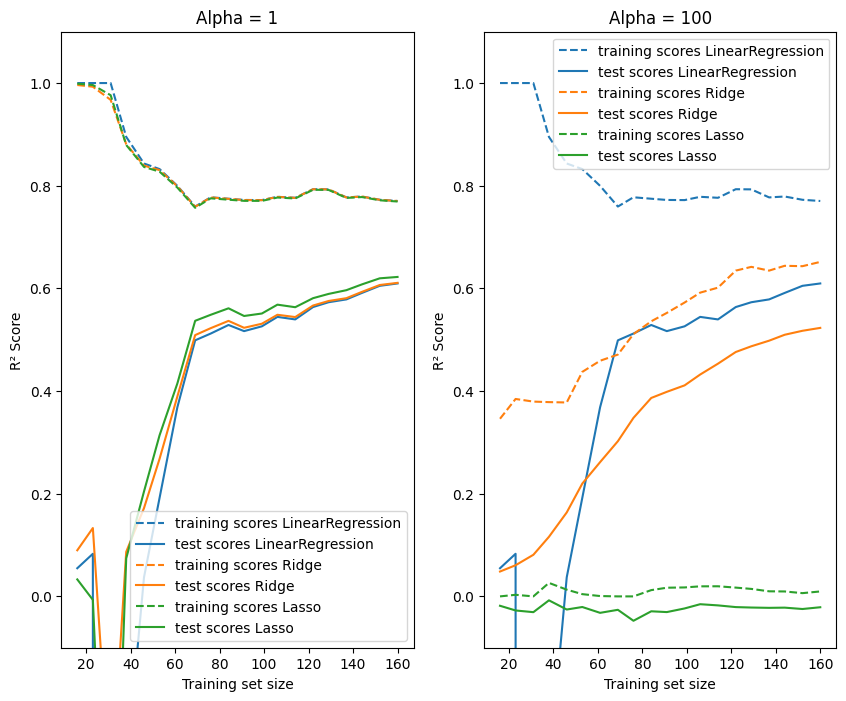

In [18]:
# Respuesta

plt.figure(figsize=(10, 8))

ax = plt.subplot(1,2,1)
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=1), X, y)
plot_learning_curve(Lasso(alpha=1), X, y)
plt.title("Alpha = 1")

ax = plt.subplot(1,2,2)
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=100), X, y)
plot_learning_curve(Lasso(alpha=100), X, y)
plt.title("Alpha = 100")



- $\alpha$ valores pequeños: el modelo ejecuta una regresión lineal
- $\alpha$ valores grandes: el modelo tiende al subajuste
- Mejora del modelo Lasso: reduce $\alpha$ o incrementa la complejidad del modelo (añade valores útiles).
- Mejora del modelo Ridge: puede ser realizada como en el modelo Lasso.
